# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo2.npy')
print(sample[0,:])

[ 155.  157.  159. ...,  180.  180.  180.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

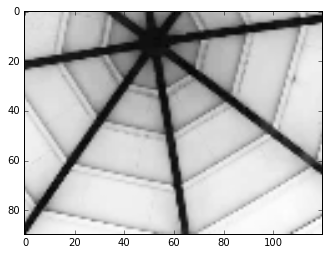

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
sample_max = sample[:,:].max()
sample_min = sample[:,:].min()
print(sample_min, sample_max)

18.0 192.0


In [5]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm)
print(sample_mean)
print(sample_std)

[[ 0.71639979  0.77022819  0.82405659 ...,  1.38925481  1.38925481
   1.38925481]
 [ 0.74331399  0.77022819  0.79714239 ...,  1.36234061  1.38925481
   1.33542641]
 [ 0.77022819  0.77022819  0.74331399 ...,  1.33542641  1.38925481
   1.38925481]
 ..., 
 [ 0.09737317  0.07045897  0.01663056 ...,  1.25468381  1.30851221
   1.30851221]
 [ 0.01663056 -1.03302327 -2.19033392 ...,  1.25468381  1.30851221
   1.30851221]
 [-2.21724812 -2.27107652 -2.24416232 ...,  1.22776961  1.30851221
   1.36234061]]
128.38208963
37.1551063551


Define combined kernel using GPy library:

In [6]:
import GPy

kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)
#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
#kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [7]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=1000)

Extract latent X from the model:

In [8]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |         1.65895406  |               |        
  [0 1]      |        -1.00456756  |               |        
  [0 2]      |         1.20853123  |               |        
  [0 3]      |        -0.73681975  |               |        
  [0 4]      |         1.57595914  |               |        
  [0 5]      |        -0.62365065  |               |        
  [0 6]      |         1.20690613  |               |        
  [0 7]      |        -1.27831938  |               |        
  [0 8]      |        -0.88532114  |               |        
  [0 9]      |         1.10696023  |               |        
  [ 0 10]    |        -0.97603361  |               |        
  [ 0 11]    |         1.29768630  |               |        
  [ 0 12]    |        -0.38548043  |               |        
  [ 0 13]    |         1.28147200  |               |        
  [ 0 14]    |        -0.36640802  |               |        
  [ 0 15]    |         1

Plot first 5 values to visualize:

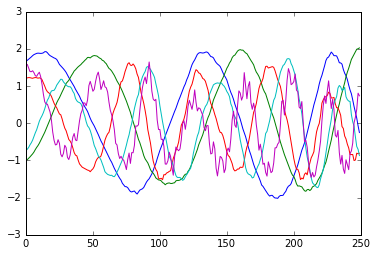

In [9]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [10]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 1.12723122  1.12453641  1.11570887 ...,  0.37482989  0.36072992
   0.34014724]
 [ 1.12453641  1.12736064  1.12367533 ...,  0.37679995  0.36238376
   0.3414967 ]
 [ 1.11570887  1.12367533  1.12739518 ...,  0.37992032  0.36516094
   0.34393555]
 ..., 
 [ 0.37482989  0.37679995  0.37992032 ...,  1.12504682  1.08360452
   1.01668519]
 [ 0.36072992  0.36238376  0.36516094 ...,  1.08360452  1.1256725
   1.08323239]
 [ 0.34014724  0.3414967   0.34393555 ...,  1.01668519  1.08323239
   1.12619333]]


Function to predict new artificial frame using mean prediction method:

In [11]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [12]:
N_synt = 250  #for evaluation - the same number as in the input
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[-0.39866502  1.97521065 -0.65126206 ..., -2.70453102  0.74725743
  -0.38259868]
 [-0.53792272  1.9142033  -0.49564003 ..., -1.95617925  0.7688353
  -0.76721275]
 [-0.67375005  1.84689485 -0.35190004 ..., -1.45227025  0.75415243
  -1.06387136]
 ..., 
 [ 1.04904995  1.45794158 -0.64163813 ...,  0.86505817 -1.4573894
   0.57622069]
 [ 0.91323173  1.56999401 -0.82079483 ...,  0.14613165 -1.71508401
   0.37870031]
 [ 0.81154206  1.69572782 -0.84974036 ..., -0.28671413 -1.79410464
  -0.93656714]]


Plot of new X:

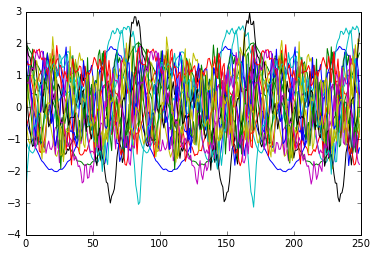

In [13]:
mp.plot(X_synt)

Now perform syntesis of new dinamic texture by mean prediction

In [14]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)

Y_synt = np.transpose(meann)
    
print(Y_synt)

[[-2.5128956  -2.25084704 -1.98543273 ...,  1.24529864  1.318696    1.3818383 ]
 [-2.04519814 -2.15433507 -2.25778159 ...,  1.26804948  1.32081462
   1.36575127]
 [-2.21707607 -2.54715263 -2.72712608 ...,  1.29430724  1.33306621
   1.35645163]
 ..., 
 [ 0.43148302  0.45528234  0.4811794  ...,  1.33530821  1.33556242
   1.33526036]
 [ 0.3718939   0.39827994  0.42658625 ...,  1.33448429  1.33444289
   1.33473407]
 [ 0.36453568  0.39584471  0.40574032 ...,  1.33772262  1.33796527
   1.33799356]]


Display first frame:

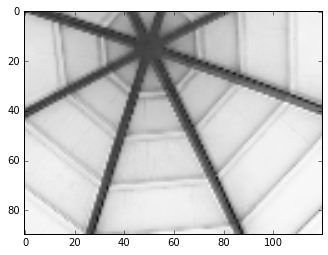

In [15]:
show_frame(Y_synt[0,:])

Denormalization:

In [16]:
Y_synt_denorm = sample_std * Y_synt + sample_mean
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)
print(sample_min,sample_max)

4.52624887366 189.287335801
18.0 192.0


In [17]:
sample_mean2 = np.mean(Y_synt_denorm)
sample_std2 = np.std(Y_synt_denorm)

print(sample_mean,sample_std)
print(sample_mean2,sample_std2)

128.38208963 37.1551063551
126.703740843 37.6212036015


Now compute Mean Sqare Error:

677.063437986
1495.91286157
2003.3344879


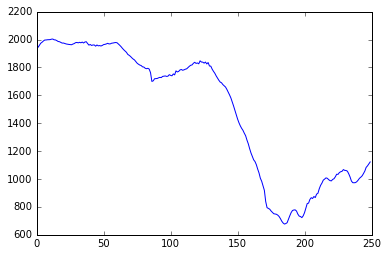

In [18]:
MSE = (1/D)*((sample - Y_synt_denorm)**2).sum(1)
print(MSE.min())
print(np.mean(MSE))
print(MSE.max())
mp.plot(MSE)

Finally, save synthesized video:

In [19]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\out_meanpred.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Done!
